In [1]:
from transformers import AutoModel, AutoImageProcessor
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image


/Users/ankitsanjyal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).eval()

img_path = "../data/sample_chair.png"
img = Image.open(img_path).convert("RGB")
inputs = processor(images=img, return_tensors="pt")


In [3]:
with torch.no_grad():
    outputs = model(**inputs)
features = outputs.last_hidden_state  # [1, 257, 768]
patch_tokens = features[:, 1:, :]     # remove CLS token → [1, 256, 768]


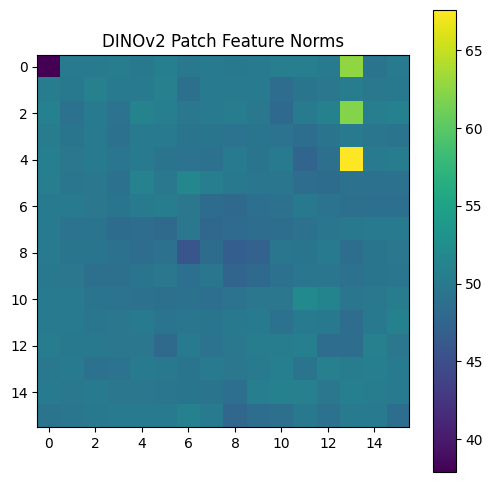

In [4]:
norms = torch.norm(patch_tokens, dim=-1).reshape(16, 16).cpu().numpy()

plt.figure(figsize=(6, 6))
plt.title("DINOv2 Patch Feature Norms")
plt.imshow(norms, cmap="viridis")
plt.colorbar()
plt.show()


/var/folders/wz/r4kjttqd25b0x01c0vl1b7gw0000gn/T/ipykernel_5866/1867969996.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load("../features/sample_chai

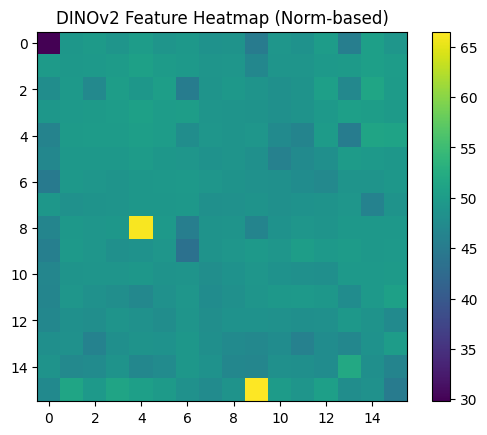

In [9]:
import torch
import matplotlib.pyplot as plt

# Load saved feature
features = torch.load("../features/sample_chair.pt")  # [1, 256, 768]

# Convert to numpy and reshape
features = features.squeeze(0)  # [256, 768]

# Optional: reduce 768-d to 1 scalar per patch using L2 norm or mean
heatmap = features.norm(dim=-1)  # or features.mean(dim=-1) → [256]

# Reshape to 16x16 grid
heatmap = heatmap.reshape(16, 16).detach().cpu().numpy()

# Plot heatmap
plt.imshow(heatmap, cmap="viridis")
plt.title("DINOv2 Feature Heatmap (Norm-based)")
plt.colorbar()
plt.show()


/var/folders/wz/r4kjttqd25b0x01c0vl1b7gw0000gn/T/ipykernel_5866/3588245364.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load("../features/sample_cha

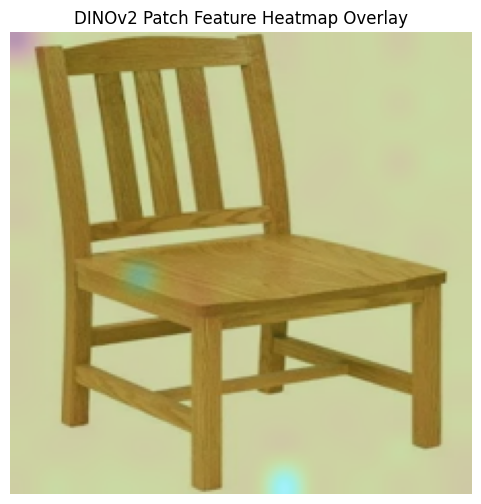

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Load original image (same as used for feature extraction)
img_path = "../data/sample_chair.png"
orig_img = Image.open(img_path).convert("RGB").resize((224, 224))
orig_np = np.array(orig_img)

# Load features and compute 16x16 heatmap
features = torch.load("../features/sample_chair.pt").squeeze(0)  # [256, 768]
heatmap = features.norm(dim=-1).reshape(16, 16).cpu().numpy()

# Resize heatmap to 224x224
heatmap_resized = cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_CUBIC)
heatmap_resized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.ptp() + 1e-5)
heatmap_colored = cv2.applyColorMap((255 * heatmap_resized).astype(np.uint8), cv2.COLORMAP_VIRIDIS)

# Blend with original image
overlay = cv2.addWeighted(orig_np, 0.6, heatmap_colored, 0.4, 0)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title("DINOv2 Patch Feature Heatmap Overlay")
plt.axis("off")
plt.show()


/var/folders/wz/r4kjttqd25b0x01c0vl1b7gw0000gn/T/ipykernel_5866/2205785845.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load("../features/sample_chai

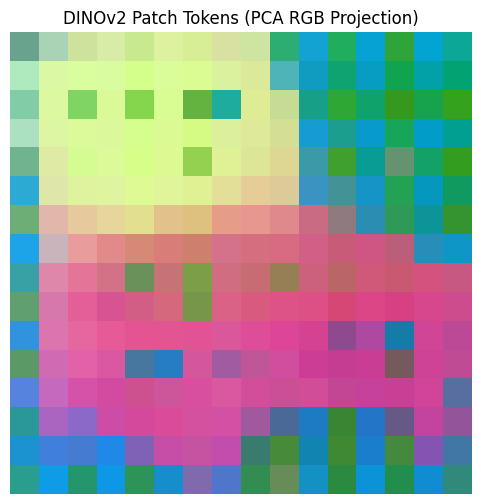

In [12]:
from sklearn.decomposition import PCA

# features: [256, 768]
features = torch.load("../features/sample_chair.pt").squeeze(0)

# Reduce to 3D for visualization
pca = PCA(n_components=3)
proj = pca.fit_transform(features.cpu().numpy())  # [256, 3]
proj = (proj - proj.min()) / (proj.max() - proj.min())  # Normalize to [0,1]

# Reshape to 16x16 grid and plot as RGB
proj_img = proj.reshape(16, 16, 3)
proj_img = (proj_img * 255).astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(proj_img)
plt.title("DINOv2 Patch Tokens (PCA RGB Projection)")
plt.axis("off")
plt.show()
